In [32]:
!pip install simpy


ULTIMA VERSIUNE

In [40]:
import simpy
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import math

class BikeIssue:
    """Represents different types of bike maintenance issues"""
    ISSUES = {
        'roata_sparta': {'name': 'Roată spartă', 'repair_time': 720, 'probability': 0.55},
        'pedala_slabita': {'name': 'Pedală slăbită', 'repair_time': 720, 'probability': 0.3},
        'pedala_rupta': {'name': 'Pedală ruptă', 'repair_time': 1440, 'probability': 0.2},
        'lant_ruginit': {'name': 'Lanț ruginit', 'repair_time': 1440, 'probability': 0.33},
        'discuri_indoite': {'name': 'Discuri de frâne îndoite', 'repair_time': 4320, 'probability': 0.15},
        'ghidon_slabit': {'name': 'Ghidon slăbit', 'repair_time': 2880, 'probability': 0.3},
        'sa_slabita': {'name': 'Șa slăbită', 'repair_time': 720, 'probability': 0.45},
        'cadru_fisurat': {'name': 'Cadru fisurat', 'repair_time': 7200, 'probability': 0.25}
    }

class Station:
    def __init__(self, env, name, capacity, init_bikes):
        # env este acum obligatoriu și inițializat corect de run_simulation
        self.env = env
        self.name = name
        self.capacity = capacity
        self.bikes = simpy.Container(env, init=init_bikes, capacity=capacity)
        self.broken_bikes = 0

class RepairShop:
    def __init__(self, env, num_mechanics=2):
        self.env = env
        self.mechanics = simpy.Resource(env, capacity=num_mechanics)
        self.bikes_in_repair = []
        self.repair_stats = defaultdict(int)

    def repair_bike(self, bike_id, issue_type, issue_info, return_station):
        self.bikes_in_repair.append((bike_id, issue_type, self.env.now))
        self.repair_stats[issue_type] += 1

        with self.mechanics.request() as request:
            yield request
            yield self.env.timeout(issue_info['repair_time'])

            self.bikes_in_repair = [(bid, it, t) for bid, it, t in self.bikes_in_repair if bid != bike_id]

            if return_station.bikes.level < return_station.capacity:
                yield return_station.bikes.put(1)
                return_station.broken_bikes -= 1

class RebalancingTruck:
    def __init__(self, env, stations, rebalancing_stats, rebalancing_interval):
        self.env = env
        self.stations = stations
        self.rebalancing_stats = rebalancing_stats
        self.rebalancing_interval = rebalancing_interval

    def rebalance(self):
        while True:
            yield self.env.timeout(self.rebalancing_interval)

            stations_needing_bikes = []
            stations_with_surplus = []

            for station in self.stations:
                current_bikes = station.bikes.level
                half_capacity = station.capacity / 2

                if current_bikes < half_capacity:
                    bikes_needed = math.floor(half_capacity - current_bikes) + 1
                    stations_needing_bikes.append((station, bikes_needed))
                elif current_bikes >= (half_capacity + 1):
                    bikes_available = math.floor(current_bikes - half_capacity)
                    stations_with_surplus.append((station, bikes_available))

            if stations_needing_bikes and stations_with_surplus:
                stations_with_surplus_mutable = list(stations_with_surplus)

                for needy_station, bikes_needed_original in stations_needing_bikes:
                    bikes_needed = bikes_needed_original
                    if bikes_needed == 0:
                        continue

                    for i, (surplus_station, bikes_available) in enumerate(stations_with_surplus_mutable):
                        if bikes_needed == 0:
                            break

                        if bikes_available <= 0:
                             continue

                        transfer_amount = min(bikes_needed, bikes_available)

                        if transfer_amount > 0:
                            yield surplus_station.bikes.get(transfer_amount)
                            yield needy_station.bikes.put(transfer_amount)

                            bikes_needed -= transfer_amount

                            stations_with_surplus_mutable[i] = (surplus_station, bikes_available - transfer_amount)

                            self.rebalancing_stats['total_transfers'] += transfer_amount
                            self.rebalancing_stats['operations'] += 1

def check_bike_failure(failure_probability=0.08):
    if random.uniform(0, 1) < failure_probability:
        total_prob = sum(issue['probability'] for issue in BikeIssue.ISSUES.values())
        rand_val = random.uniform(0, total_prob)

        cumulative = 0
        for issue_type, issue_info in BikeIssue.ISSUES.items():
            cumulative += issue_info['probability']
            if rand_val <= cumulative:
                return issue_type, issue_info
    return None, None

def bike_trip(env, from_station, to_station, trip_duration, repair_shop, bike_id,
              trip_stats, customer_satisfaction, failure_probability):
    if from_station.bikes.level > 0:
        yield from_station.bikes.get(1)
        trip_stats['successful_trips'] += 1
    else:
        trip_stats['failed_no_bikes'] += 1
        customer_satisfaction['unhappy_no_bikes'] += 1
        customer_satisfaction['unhappy_by_station'][from_station.name]['no_bikes'] += 1
        return

    yield env.timeout(trip_duration)

    issue_type, issue_info = check_bike_failure(failure_probability)

    if issue_type:
        trip_stats['bikes_broken'] += 1
        to_station.broken_bikes += 1
        env.process(repair_shop.repair_bike(bike_id, issue_type, issue_info, to_station))
        return

    if to_station.bikes.level < to_station.capacity:
        yield to_station.bikes.put(1)
    else:
        trip_stats['failed_no_docks'] += 1
        customer_satisfaction['unhappy_no_docks'] += 1
        customer_satisfaction['unhappy_by_station'][to_station.name]['no_docks'] += 1

        yield env.timeout(trip_duration)
        if from_station.bikes.level < from_station.capacity:
            yield from_station.bikes.put(1)

def get_time_slot(current_time):
    time_in_day = current_time % 1440
    if 420 <= time_in_day < 600:
        return "morning_rush"
    elif 600 <= time_in_day < 1020:
        return "midday"
    elif 1020 <= time_in_day < 1200:
        return "evening_rush"
    else:
        return "night"

def generate_trips(env, stations, prob_matrices, repair_shop, trip_stats,
                   customer_satisfaction, failure_probability):
    bike_counter = 1
    while True:
        current_slot = get_time_slot(env.now)
        prob_matrix = prob_matrices[current_slot]

        for (from_station, to_station), prob in prob_matrix.items():
            if random.uniform(0, 1) < prob:
                trip_duration = random.randint(5, 15)
                env.process(bike_trip(env, from_station, to_station, trip_duration,
                                     repair_shop, bike_counter, trip_stats,
                                     customer_satisfaction, failure_probability))
                bike_counter += 1

        yield env.timeout(1)

def monitor_stations(env, stations, bike_levels, repair_shop, maintenance_stats, customer_satisfaction):
    while True:
        for station in stations:
            bike_levels[station.name].append((env.now, station.bikes.level))

        maintenance_stats['bikes_in_repair'].append((env.now, len(repair_shop.bikes_in_repair)))
        maintenance_stats['mechanics_busy'].append((env.now, repair_shop.mechanics.count))

        total_unhappy = customer_satisfaction['unhappy_no_bikes'] + customer_satisfaction['unhappy_no_docks']
        customer_satisfaction['unhappy_over_time'].append((env.now, total_unhappy))

        yield env.timeout(1)

def plot_results(bike_levels, maintenance_stats, repair_shop, customer_satisfaction,
                 stations, simulation_duration, rebalancing_interval):
    fig, axes = plt.subplots(6, 1, figsize=(14, 20))

    time_slots = {
        'Morning Rush': (420, 600, '#FFE5B4'),
        'Midday': (600, 1020, '#E0F0FF'),
        'Evening Rush': (1020, 1200, '#FFD4D4'),
        'Night': [(0, 420, '#E8E8E8'), (1200, 1440, '#E8E8E8')]
    }

    # Calculează numărul de zile pentru a afișa corect fundalul
    num_days = math.ceil(simulation_duration / 1440)

    # Plot 1: Bike levels over time
    ax1 = axes[0]
    for station_name, levels in bike_levels.items():
        if levels:
             times, counts = zip(*levels)
             ax1.plot(times, counts, label=station_name, linewidth=2)

    for day in range(num_days):
        offset = day * 1440
        for slot_name, slot_info in time_slots.items():
            if isinstance(slot_info, tuple):
                ax1.axvspan(offset + slot_info[0], offset + slot_info[1],
                            alpha=0.2, color=slot_info[2])
            else:
                for period in slot_info:
                    ax1.axvspan(offset + period[0], offset + period[1],
                                alpha=0.2, color=period[2])

    for i in range(0, simulation_duration, rebalancing_interval):
        ax1.axvline(x=i, color='green', linestyle='--', alpha=0.3, linewidth=1)

    ax1.set_xlabel('Time (minutes)', fontsize=12)
    ax1.set_ylabel('Number of Bikes', fontsize=12)
    ax1.set_title(f'Bike Levels at Each Station Over Time ({simulation_duration/1440:.1f} Days)',
                  fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)

    # Plot 2: Maintenance tracking
    ax2 = axes[1]
    if maintenance_stats['bikes_in_repair']:
        times, counts = zip(*maintenance_stats['bikes_in_repair'])
        ax2.plot(times, counts, label='Bikes in Repair', linewidth=2, color='red')
        ax2.fill_between(times, counts, alpha=0.3, color='red')

    ax2.set_xlabel('Time (minutes)', fontsize=12)
    ax2.set_ylabel('Number of Bikes', fontsize=12)
    ax2.set_title('Bikes Under Maintenance Over Time', fontsize=14, fontweight='bold')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    # Plot 3: Repair statistics
    ax3 = axes[2]
    issue_names = [BikeIssue.ISSUES[k]['name'] for k in repair_shop.repair_stats.keys()]
    issue_counts = list(repair_shop.repair_stats.values())

    if issue_counts:
        bars = ax3.barh(issue_names, issue_counts, color='steelblue', edgecolor='black')
        ax3.set_xlabel('Number of Occurrences', fontsize=12)
        ax3.set_ylabel('Issue Type', fontsize=12)
        ax3.set_title('Bike Maintenance Issues Distribution', fontsize=14, fontweight='bold')
        ax3.grid(True, alpha=0.3, axis='x')

        for bar, count in zip(bars, issue_counts):
            width = bar.get_width()
            ax3.text(width, bar.get_y() + bar.get_height()/2., f'{count}',
                     ha='left', va='center', fontsize=10, fontweight='bold')

    # Plot 4: Station balance
    ax4 = axes[3]
    for station_name, levels in bike_levels.items():
        if levels:
             times, counts = zip(*levels)
             station = next(s for s in stations if s.name == station_name)
             percentages = [count / station.capacity * 100 for count in counts]
             ax4.plot(times, percentages, label=station_name, linewidth=2)

    ax4.axhline(y=50, color='red', linestyle='--', alpha=0.5, linewidth=2, label='50% Threshold')
    ax4.set_xlabel('Time (minutes)', fontsize=12)
    ax4.set_ylabel('Capacity Utilization (%)', fontsize=12)
    ax4.set_title('Station Balance Over Time', fontsize=14, fontweight='bold')
    ax4.legend(loc='upper right')
    ax4.grid(True, alpha=0.3)

    # Plot 5: Customer satisfaction by station
    ax5 = axes[4]
    station_names = list(customer_satisfaction['unhappy_by_station'].keys())
    no_bikes_counts = [customer_satisfaction['unhappy_by_station'][name]['no_bikes'] for name in station_names]
    no_docks_counts = [customer_satisfaction['unhappy_by_station'][name]['no_docks'] for name in station_names]

    x = range(len(station_names))
    width = 0.35

    bars1 = ax5.bar([i - width/2 for i in x], no_bikes_counts, width,
                    label='Unhappy - No Bikes', color='#FF6B6B', edgecolor='black')
    bars2 = ax5.bar([i + width/2 for i in x], no_docks_counts, width,
                    label='Unhappy - No Docks', color='#FFA500', edgecolor='black')

    ax5.set_xlabel('Station', fontsize=12)
    ax5.set_ylabel('Number of Unhappy Customers', fontsize=12)
    ax5.set_title('Customer Satisfaction Issues by Station', fontsize=14, fontweight='bold')
    ax5.set_xticks(x)
    ax5.set_xticklabels(station_names)
    ax5.legend()
    ax5.grid(True, alpha=0.3, axis='y')

    for bar in bars1:
        height = bar.get_height()
        if height > 0:
            ax5.text(bar.get_x() + bar.get_width()/2., height,
                     f'{int(height)}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    for bar in bars2:
        height = bar.get_height()
        if height > 0:
            ax5.text(bar.get_x() + bar.get_width()/2., height,
                     f'{int(height)}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Plot 6: Unhappy customers over time
    ax6 = axes[5]
    if customer_satisfaction['unhappy_over_time']:
        times, counts = zip(*customer_satisfaction['unhappy_over_time'])
        ax6.plot(times, counts, label='Cumulative Unhappy Customers', linewidth=2, color='#FF6B6B')
        ax6.fill_between(times, counts, alpha=0.3, color='#FF6B6B')

    for day in range(num_days):
        offset = day * 1440
        for slot_name, slot_info in time_slots.items():
            if isinstance(slot_info, tuple):
                ax6.axvspan(offset + slot_info[0], offset + slot_info[1],
                            alpha=0.2, color=slot_info[2])
            else:
                for period in slot_info:
                    ax6.axvspan(offset + period[0], offset + period[1],
                                alpha=0.2, color=period[2])

    ax6.set_xlabel('Time (minutes)', fontsize=12)
    ax6.set_ylabel('Cumulative Unhappy Customers', fontsize=12)
    ax6.set_title('Customer Dissatisfaction Over Time', fontsize=14, fontweight='bold')
    ax6.legend(loc='upper left')
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def print_summary(simulation_duration, trip_stats, stations, bike_levels, repair_shop,
                  maintenance_stats, rebalancing_stats, customer_satisfaction, rebalancing_interval):
    """Print comprehensive simulation summary"""
    print("\n" + "="*70)
    print("SIMULATION SUMMARY")
    print("="*70)
    print(f"Simulation Duration: {simulation_duration} minutes ({simulation_duration/1440:.1f} days)")

    print("\n" + "-"*70)
    print("TRIP STATISTICS")
    print("-"*70)
    print(f"  Successful trips: {trip_stats['successful_trips']}")
    print(f"  Failed (no bikes): {trip_stats['failed_no_bikes']}")
    print(f"  Failed (no docks): {trip_stats['failed_no_docks']}")
    print(f"  Bikes broken: {trip_stats['bikes_broken']}")
    total_attempts = trip_stats['successful_trips'] + trip_stats['failed_no_bikes']
    if total_attempts > 0:
        print(f"  Success rate: {trip_stats['successful_trips']/total_attempts*100:.1f}%")

    print("\n" + "-"*70)
    print("STATION STATISTICS")
    print("-"*70)
    for station in stations:
        levels = [count for _, count in bike_levels[station.name]]
        if levels:
            print(f"\n{station.name}:")
            print(f"  Capacity: {station.capacity}")
            print(f"  Average bikes: {sum(levels)/len(levels):.2f}")
            print(f"  Utilization: {sum(levels)/len(levels)/station.capacity*100:.1f}%")
            print(f"  Min bikes: {min(levels)}")
            print(f"  Max bikes: {max(levels)}")
            print(f"  Bikes broken at station: {station.broken_bikes}")

    print("\n" + "-"*70)
    print("MAINTENANCE STATISTICS")
    print("-"*70)
    print(f"  Total repairs completed: {sum(repair_shop.repair_stats.values())}")
    print(f"  Repair breakdown:")
    for issue_type, count in repair_shop.repair_stats.items():
        print(f"    {BikeIssue.ISSUES[issue_type]['name']}: {count}")
    print(f"  Bikes currently in repair: {len(repair_shop.bikes_in_repair)}")
    if maintenance_stats['bikes_in_repair']:
        print(f"  Peak bikes in repair: {max(count for _, count in maintenance_stats['bikes_in_repair'])}")

    print("\n" + "-"*70)
    print("REBALANCING STATISTICS")
    print("-"*70)
    print(f"  Rebalancing interval: {rebalancing_interval} minutes")
    print(f"  Total rebalancing operations: {rebalancing_stats['operations']}")
    print(f"  Total bikes transferred: {rebalancing_stats['total_transfers']}")
    if rebalancing_stats['operations'] > 0:
        print(f"  Average bikes per operation: {rebalancing_stats['total_transfers']/rebalancing_stats['operations']:.1f}")
    print(f"  Rebalancing checks: {simulation_duration // rebalancing_interval}")

    print("\n" + "-"*70)
    print("CUSTOMER SATISFACTION")
    print("-"*70)
    total_unhappy = customer_satisfaction['unhappy_no_bikes'] + customer_satisfaction['unhappy_no_docks']
    total_customers = trip_stats['successful_trips'] + trip_stats['failed_no_bikes']
    print(f"  Total unhappy customers: {total_unhappy}")
    print(f"  Unhappy due to no bikes: {customer_satisfaction['unhappy_no_bikes']}")
    print(f"  Unhappy due to no docks: {customer_satisfaction['unhappy_no_docks']}")
    if total_customers > 0:
        satisfaction_rate = ((total_customers - customer_satisfaction['unhappy_no_bikes']) / total_customers) * 100
        print(f"  Customer satisfaction rate (rental): {satisfaction_rate:.1f}%")
    if trip_stats['successful_trips'] > 0:
        return_satisfaction = ((trip_stats['successful_trips'] - customer_satisfaction['unhappy_no_docks']) / trip_stats['successful_trips']) * 100
        print(f"  Customer satisfaction rate (return): {return_satisfaction:.1f}%")

    print("\n  Unhappy customers by station:")
    for station_name in customer_satisfaction['unhappy_by_station'].keys():
        no_bikes = customer_satisfaction['unhappy_by_station'][station_name]['no_bikes']
        no_docks = customer_satisfaction['unhappy_by_station'][station_name]['no_docks']
        total = no_bikes + no_docks
        print(f"    {station_name}: {total} total (No bikes: {no_bikes}, No docks: {no_docks})")
    print("="*70)


def run_simulation(station_configs, prob_matrices, simulation_duration=2880,
                   num_mechanics=2, rebalancing_interval=120, failure_probability=0.08,
                   show_plots=True, show_summary=True):

    # 1. Inițializare Mediu SimPy
    env = simpy.Environment()

    # 2. Creare Obiecte SimPy (RepairShop și Stations)
    repair_shop = RepairShop(env, num_mechanics=num_mechanics)
    stations = [Station(env, name, capacity, init_bikes)
                for name, capacity, init_bikes in station_configs]

    # 3. Maparea Numelor la Obiecte pentru Matricea de Probabilități
    station_map = {station.name: station for station in stations}
    mapped_prob_matrices = {}
    for time_slot, prob_matrix in prob_matrices.items():
        mapped_prob_matrices[time_slot] = {
            (station_map[from_name], station_map[to_name]): prob
            for (from_name, to_name), prob in prob_matrix.items()
        }

    # 4. Inițializare Dicționare de tracking
    bike_levels = {station.name: [] for station in stations}
    maintenance_stats = {'bikes_in_repair': [], 'mechanics_busy': []}
    trip_stats = {'successful_trips': 0, 'failed_no_bikes': 0,
                  'failed_no_docks': 0, 'bikes_broken': 0}
    rebalancing_stats = {'total_transfers': 0, 'operations': 0}
    customer_satisfaction = {
        'unhappy_no_bikes': 0,
        'unhappy_no_docks': 0,
        'unhappy_by_station': {station.name: {'no_bikes': 0, 'no_docks': 0} for station in stations},
        'unhappy_over_time': []
    }

    # 5. Creare Rebalancing Truck
    rebalancing_truck = RebalancingTruck(env, stations, rebalancing_stats, rebalancing_interval)

    # 6. Pornire Procese (folosim matricea mapată)
    env.process(generate_trips(env, stations, mapped_prob_matrices, repair_shop, trip_stats,
                               customer_satisfaction, failure_probability))
    env.process(monitor_stations(env, stations, bike_levels, repair_shop,
                                 maintenance_stats, customer_satisfaction))
    env.process(rebalancing_truck.rebalance())

    # 7. Rulare Simulare
    env.run(until=simulation_duration)

    # 8. Afișare Rezultate
    if show_plots:
        # Aici presupunem că funcția plot_results este definită
        plot_results(bike_levels, maintenance_stats, repair_shop, customer_satisfaction,
                     stations, simulation_duration, rebalancing_interval)

    if show_summary:
        # Aici presupunem că funcția print_summary este definită
        print_summary(simulation_duration, trip_stats, stations, bike_levels, repair_shop,
                      maintenance_stats, rebalancing_stats, customer_satisfaction, rebalancing_interval)

    # 9. Returnare Rezultate
    return {
        'trip_stats': trip_stats,
        'customer_satisfaction': customer_satisfaction,
        # ... alte rezultate
    }



In [41]:
STATION_CONFIGS = [
    ("UPT", 13, 8),
    ("Center", 12, 6),
    ("P700", 15, 10),
    ("Michelangelo", 10, 5)
]

prob_matrices_realistic = {
    "morning_rush": {
        ("P700", "UPT"): 0.020,
        ("P700", "Center"): 0.015,
        ("Michelangelo", "UPT"): 0.015,
        ("Michelangelo", "Center"): 0.010,
        ("UPT", "Center"): 0.008,
        ("Center", "UPT"): 0.005,
        ("Center", "P700"): 0.003,
        ("UPT", "Michelangelo"): 0.002,
    },
    "midday": {
        ("UPT", "Center"): 0.007,
        ("Center", "UPT"): 0.007,
        ("P700", "Michelangelo"): 0.005,
        ("Michelangelo", "P700"): 0.005,
        ("UPT", "P700"): 0.004,
        ("Center", "P700"): 0.004,
    },
    "evening_rush": {
        ("UPT", "P700"): 0.025,
        ("UPT", "Michelangelo"): 0.015,
        ("Center", "P700"): 0.020,
        ("Center", "Michelangelo"): 0.010,
        ("P700", "Michelangelo"): 0.005,
        ("Michelangelo", "P700"): 0.003,
    },
    "night": {
        ("UPT", "Center"): 0.001,
        ("Center", "UPT"): 0.001,
        ("P700", "Center"): 0.0005,
        ("Michelangelo", "Center"): 0.0005,
        ("P700", "UPT"): 0.0005,
    }
}

SIMULATION_DURATION_DAYS = 20
SIMULATION_DURATION_MINUTES = SIMULATION_DURATION_DAYS * 1440

NUM_MECHANICS = 2
REBALANCING_INTERVAL = 480 # 8 ore
FAILURE_PROBABILITY = 0.08

print(f"Parametrii configurați: Rulare pentru {SIMULATION_DURATION_DAYS} zile ({SIMULATION_DURATION_MINUTES} minute)")
print("Acum puteți rula Celula 3 pentru a începe simularea.")

Parametrii configurați: Rulare pentru 20 zile (28800 minute)
Acum puteți rula Celula 3 pentru a începe simularea.


Rularea simulării de bază pentru 20 zile...


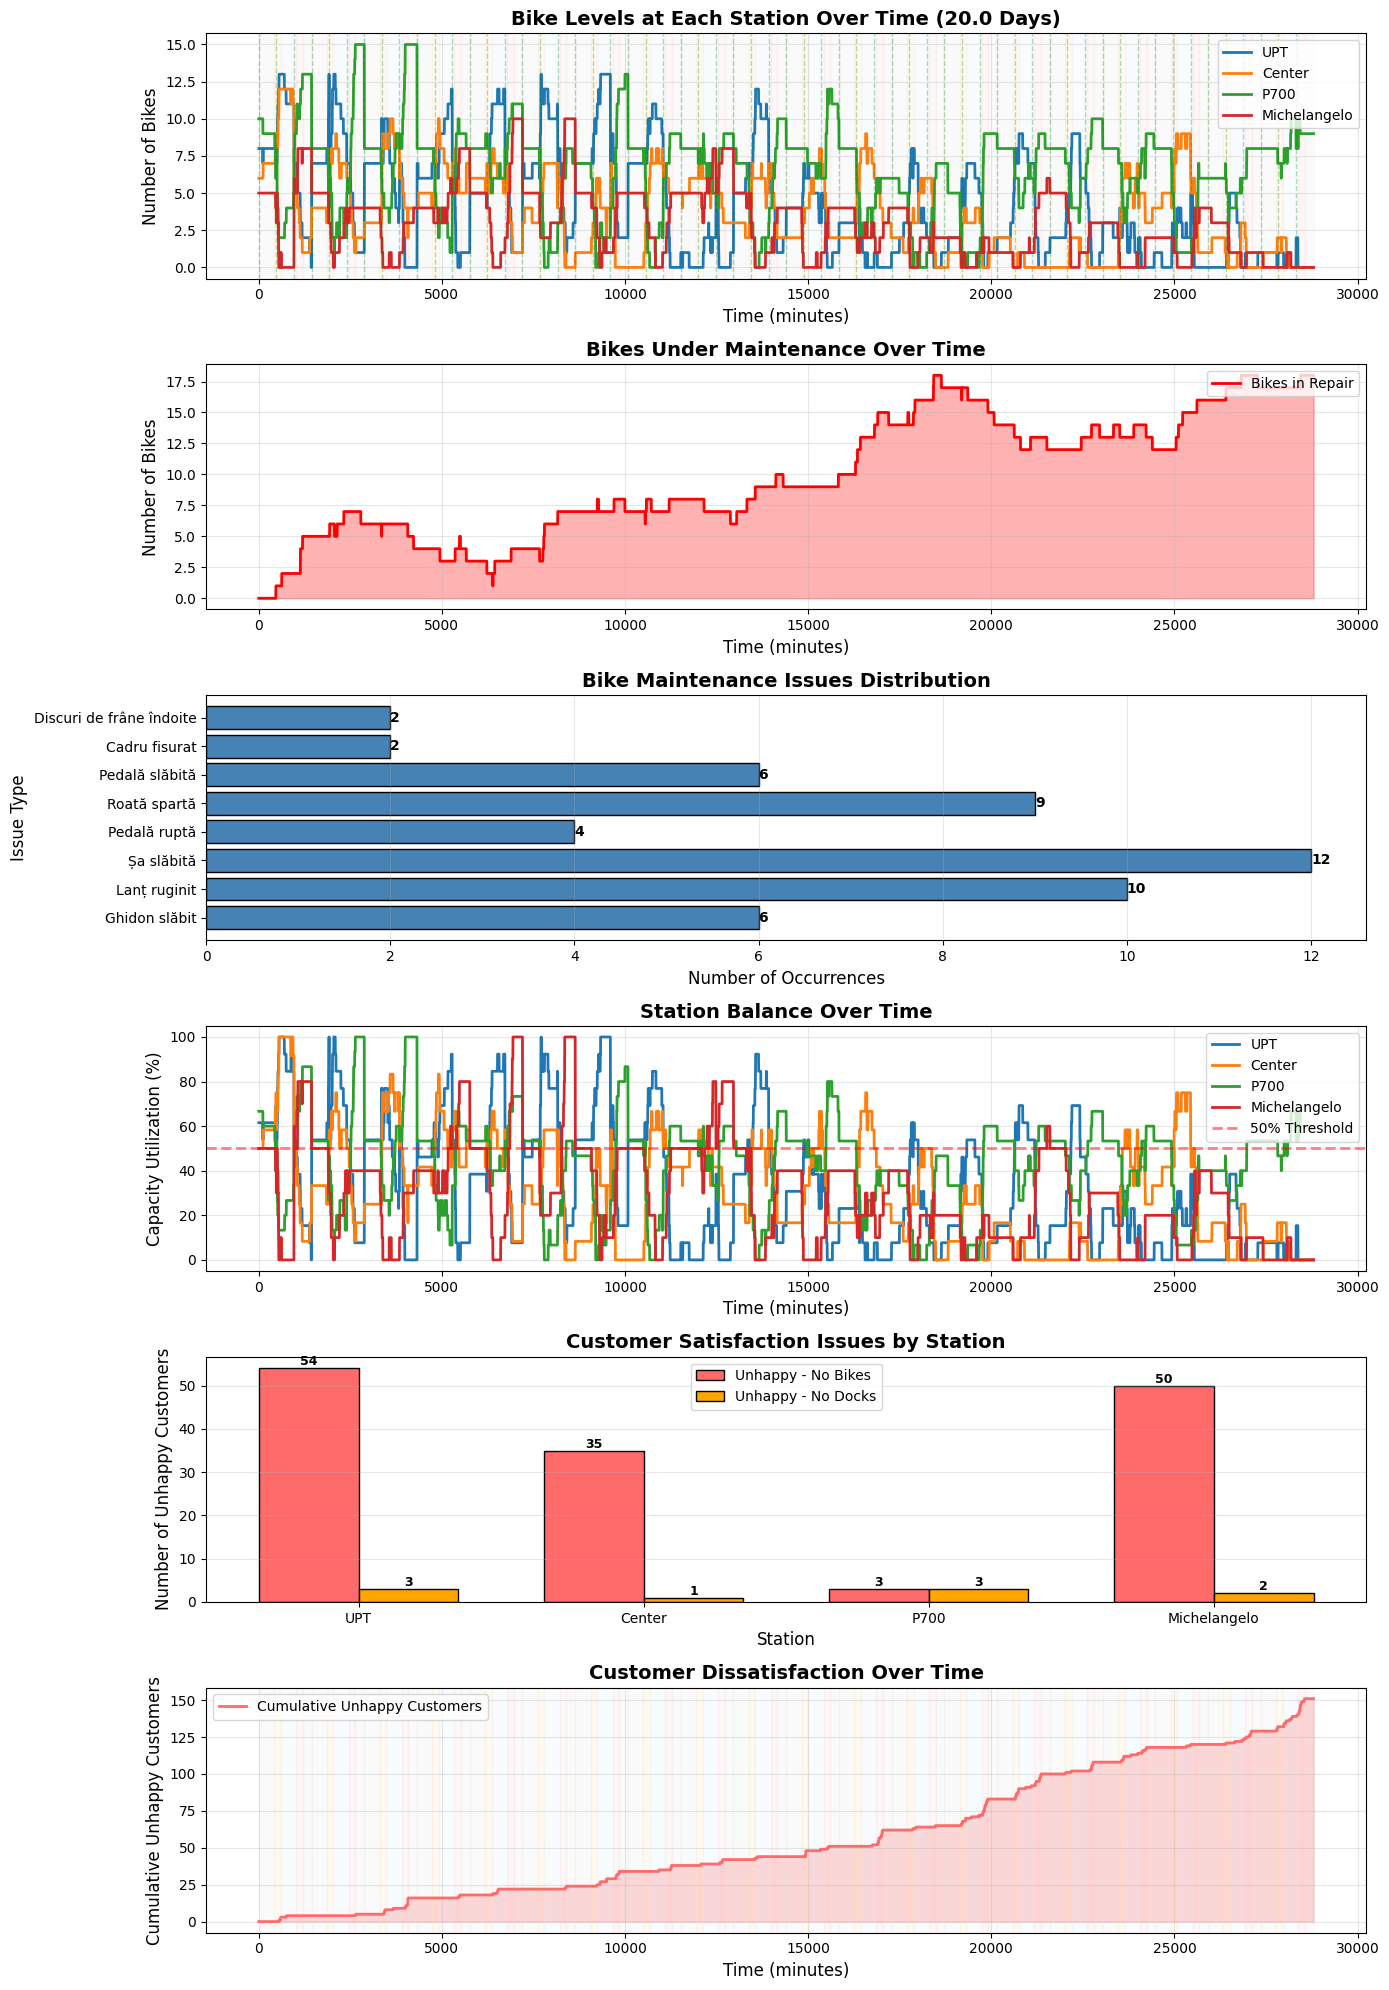


SIMULATION SUMMARY
Simulation Duration: 28800 minutes (20.0 days)

----------------------------------------------------------------------
TRIP STATISTICS
----------------------------------------------------------------------
  Successful trips: 651
  Failed (no bikes): 142
  Failed (no docks): 9
  Bikes broken: 51
  Success rate: 82.1%

----------------------------------------------------------------------
STATION STATISTICS
----------------------------------------------------------------------

UPT:
  Capacity: 13
  Average bikes: 4.13
  Utilization: 31.7%
  Min bikes: 0
  Max bikes: 13
  Bikes broken at station: 4

Center:
  Capacity: 12
  Average bikes: 3.55
  Utilization: 29.6%
  Min bikes: 0
  Max bikes: 12
  Bikes broken at station: 2

P700:
  Capacity: 15
  Average bikes: 6.59
  Utilization: 43.9%
  Min bikes: 0
  Max bikes: 15
  Bikes broken at station: 10

Michelangelo:
  Capacity: 10
  Average bikes: 2.93
  Utilization: 29.3%
  Min bikes: 0
  Max bikes: 10
  Bikes broken at 

In [42]:

print(f"Rularea simulării de bază pentru {SIMULATION_DURATION_DAYS} zile...")


base_results = run_simulation(
    station_configs=STATION_CONFIGS,
    prob_matrices=prob_matrices_realistic,
    simulation_duration=SIMULATION_DURATION_MINUTES,
    num_mechanics=NUM_MECHANICS,
    rebalancing_interval=REBALANCING_INTERVAL,
    failure_probability=FAILURE_PROBABILITY,
    show_plots=True,
    show_summary=True
)